In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib

In [2]:
from astropy.coordinates import EarthLocation, SkyCoord, AltAz, ICRS, get_sun, get_moon
from astropy.visualization import quantity_support
import astropy.units as u
from astropy.time import Time
import numpy as np

In [5]:
def compute_source_visibility(coordinates, observatory_location, year=2012):
    
    
    # Define array of times (1 day intervals)
    time_x_step = 1 * u.day
    time_x_stop = 1 * u.year
    time_x_intervals = np.arange(0, time_x_stop.to(time_x_step.unit).value + time_x_step.value, time_x_step.value) * u.day
    
    time_y_step = 0.1 * u.hour
    time_y_stop = 1 * u.day
    time_y_intervals = np.arange(0, time_y_stop.to(time_y_step.unit).value + time_y_step.value, time_y_step.value) * u.hour
    
    degrees = np.array([25, 35, 45, 55, 65, 75, 85]) * u.deg
    visibility = np.zeros((len(source_name), len(degrees))) * u.hour
    time_start = Time('%s-01-01 00:00:00' %year, scale='utc')
    sun_altitudes = np.zeros(time_x_intervals.shape + time_y_intervals.shape) * u.deg
    moon_altitudes = np.zeros(time_x_intervals.shape + time_y_intervals.shape) * u.deg
    
    X, Y = np.meshgrid(time_x_intervals, time_y_intervals)

    X = Time(time_start + X)

    figure_list = []
    
    for i, source_coordinates in enumerate(coordinates):
                
        altitudes = np.zeros(time_x_intervals.shape + time_y_intervals.shape) * u.deg
        
        for j, day in enumerate(time_x_intervals):
            
            times = Time(time_start + day + time_y_intervals)

            # Get AltAz coordinates
            altaz = AltAz(obstime=times, location=observatory_location)
            source_altaz = source_coordinates.transform_to(altaz)
            sun_altaz = get_sun(times).transform_to(altaz)
            moon_altaz = get_moon(times).transform_to(altaz)


            # Get altitude over horizon
            altitudes[j] = source_altaz.alt.to('deg')
            if i==0:
                sun_altitudes[j] = sun_altaz.alt.to('deg')
                moon_altitudes[j] = moon_altaz.alt.to('deg')
                sun_down = sun_altitudes < -10. * u.deg
                moon_down = moon_altitudes < 0. * u.deg
                
                
        masked_altitudes = altitudes #np.ma.array(altitudes, mask=~(sun_down * moon_down))
        
        
        for m in range(len(degrees)):
            
            temp = np.ma.array(altitudes, mask=~(sun_down * moon_down * (altitudes > degrees[m])))
            visibility[i, m] = time_y_step * time_x_step.value * temp.count()
        
        cmap = matplotlib.cm.viridis
        cmap.set_bad('k')
        
        z_min, z_max = 0 * u.deg , 90 * u.deg
        
        with quantity_support():
            
            fig = plt.figure()
            plt.title('Year : %s, Site : (%0.2f, %0.2f) deg , RA : %0.2f, DEC : %0.2f' %(year, observatory_location.latitude.value, observatory_location.longitude.value, source_coordinates.ra.value, source_coordinates.dec.value), fontdict={'fontsize':8})
            plt.imshow(masked_altitudes.T, cmap=cmap, vmin=z_min.value, vmax=z_max.value, aspect='auto', origin='lower')
            plt.ylabel('time (UTC)')
            plt.xlabel('day')
            #plt.yticks(np.arange(0, 24, 1), np.arange(0, 24, 1))
            #plt.xticks(np.arange(0, 365, (365/12)), np.arange(0, 12, 1))
            plt.yticks(np.linspace(0, sun_altitudes.shape[1], num=24), np.arange(0, 24, 1))
            plt.colorbar(label='elevation [deg]')
            plt.legend()
            
        figure_list.append(fig)
    
    print(visibility)

    
    with quantity_support():
    
        fig = plt.figure()
        plt.title('Year : %s, Site : (%0.2f, %0.2f) , Sun' %(year, observatory_location.latitude.value, observatory_location.longitude.value), fontdict={'fontsize':12})
        plt.imshow(sun_altitudes.T, origin='lower', aspect='auto', vmin=z_min.value, vmax=z_max.value)
        plt.xlabel('day')
        plt.ylabel('time (UTC)')
        plt.yticks(np.linspace(0, sun_altitudes.shape[1], num=24), np.arange(0, 24, 1))

        plt.colorbar(label='elevation [deg]')
        plt.legend()

        figure_list.append(fig)

        fig = plt.figure()

        plt.title('Year : %s, Site : (%0.2f, %0.2f) , Moon' %(year, observatory_location.latitude.value, observatory_location.longitude.value), fontdict={'fontsize':12})
        plt.imshow(moon_altitudes.T, origin='lower', aspect='auto', vmin=z_min.value, vmax=z_max.value)
        plt.ylabel('time (UTC)')
        plt.yticks(np.linspace(0, sun_altitudes.shape[1], num=24), np.arange(0, 24, 1))
        plt.xlabel('day')
        plt.colorbar(label='elevation [deg]')
        plt.legend()
        
        figure_list.append(fig)

    return figure_list

/home/alispach/.anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


[[ 1072.1   771.9   457.      0.      0.      0.      0. ]
 [    0.      0.      0.      0.      0.      0.      0. ]
 [    0.      0.      0.      0.      0.      0.      0. ]
 [    0.      0.      0.      0.      0.      0.      0. ]
 [    0.      0.      0.      0.      0.      0.      0. ]
 [    0.      0.      0.      0.      0.      0.      0. ]
 [    0.      0.      0.      0.      0.      0.      0. ]] h


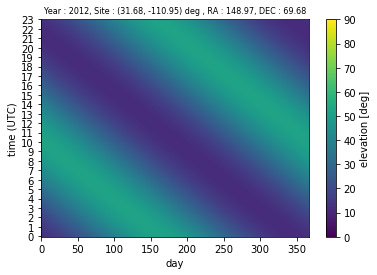

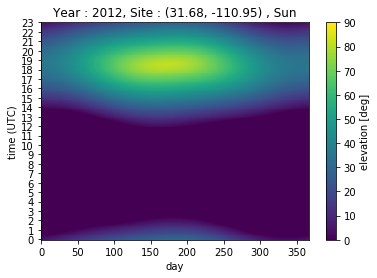

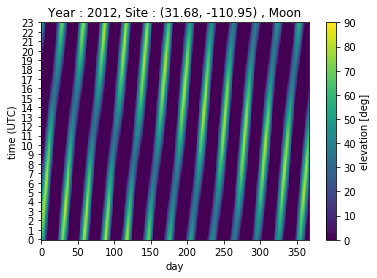

In [6]:
# Define coordinate
source_name = ['M82' ,'Crab', '3C279', 'MGRO J2031+41', 'Geminga', 'Galactic center', 'PKS234']

coordinates = [SkyCoord.from_name('M82')]#, SkyCoord.from_name('Crab'), SkyCoord.from_name('3C279'), SkyCoord.from_name('MGRO J2031+41'),SkyCoord.from_name('Geminga'),SkyCoord.from_name('Galactic Center')]
# Set location
veritas_location = EarthLocation(lat=31.675230 * u.deg, lon=-110.952012 * u.deg)
year = 2012

figure_list = compute_source_visibility(coordinates, veritas_location, year=year)

In [7]:
veritas_location.latitude.value
figure_list[0].savefig('visibility_M82_2020.pdf', format='pdf')
figure_list[1].savefig('visibility_Crab_2020.pdf', format='pdf')
figure_list[2].savefig('visibility_3C279_2020.pdf', format='pdf')
figure_list[3].savefig('visibility_MGRO J2031+41_2020.pdf', format='pdf')
figure_list[4].savefig('visibility_Geminga_2020.pdf', format='pdf')
figure_list[5].savefig('visibility_Galactic_center_2020.pdf', format='pdf')
figure_list[6].savefig('visibility_Sun_2020.pdf', format='pdf')
figure_list[7].savefig('visibility_Moon_2020.pdf', format='pdf')


IndexError: list index out of range

In [ ]:
np.atleast_2d([2,3])

In [83]:
a = 3 * u.day

In [84]:
a * 3

<Quantity 9.0 d>

In [106]:
print('%s' %a)

3.0 d
